In [12]:
import os
import sys
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import subprocess
from pathlib import Path
from rasterio.plot import show

# Configuración de Rutas
project_root = Path("..").resolve()
sys.path.append(str(project_root))

processed_dir = project_root / "data" / "processed"
vector_dir = project_root / "data" / "vector"
output_dirs = {
    "figures": project_root / "outputs" / "figures",
    "maps":    project_root / "outputs" / "maps",
    "reports": project_root / "outputs" / "reports"
}

# Cargar límite comunal para visualización estética
gdf_limite = gpd.read_file(vector_dir / "limite_comuna.gpkg")

print(f"📂 Directorio de trabajo: {project_root}")

📂 Directorio de trabajo: D:\laboratorio_cambio_urbano


In [3]:
# Definir años de análisis
YEAR_START = 2019
YEAR_END = 2025

print(f"🚀 Ejecutando detección de cambios entre {YEAR_START} y {YEAR_END}...")

script_path = project_root / "scripts" / "detect_changes.py"
cmd = [
    "python", str(script_path),
    "--t1", str(YEAR_START),
    "--t2", str(YEAR_END),
    "--method", "all"
]

# --- CORRECCIÓN AQUÍ: encoding="utf-8" ---
# Esto permite que el notebook lea los emojis sin fallar
result = subprocess.run(cmd, capture_output=True, text=True, encoding="utf-8", errors="replace")

if result.returncode == 0:
    print("✅ Procesamiento Exitoso.")
    # Imprimir el log generado por el script para ver estadísticas rápidas
    print("\n--- SALIDA DEL SCRIPT ---")
    print(result.stdout)
else:
    print("❌ Error en el script:")
    print(result.stderr)

🚀 Ejecutando detección de cambios entre 2019 y 2025...
✅ Procesamiento Exitoso.

--- SALIDA DEL SCRIPT ---
🚀 Iniciando Detección de Cambios: 2019 -> 2025
--- Ejecutando Método 1: Diferencia Simple (Banda 1) ---
Ganancia (> 0.15): 75694 px (6.3%)
Pérdida (< -0.15): 123130 px (10.2%)
💾 Guardado: cambio_diferencia_indices_2019_2025.tif
--- Ejecutando Método 2: Clasificación Urbana ---
Clase Urbanización: 74993 px (~749.9 ha)
Clase Pérdida Veg: 38364 px (~383.6 ha)
Clase Ganancia Veg: 147399 px (~1474.0 ha)
Clase Nuevo Agua: 1993 px (~19.9 ha)
💾 Guardado: cambio_urbano_2019_2025.tif
--- Ejecutando Método 3: Anomalías Temporales (Target: 2025) ---
💾 Guardado: anomalia_temporal_2025.tif

🏁 Proceso finalizado. Resultados en D:\laboratorio_cambio_urbano\data\processed



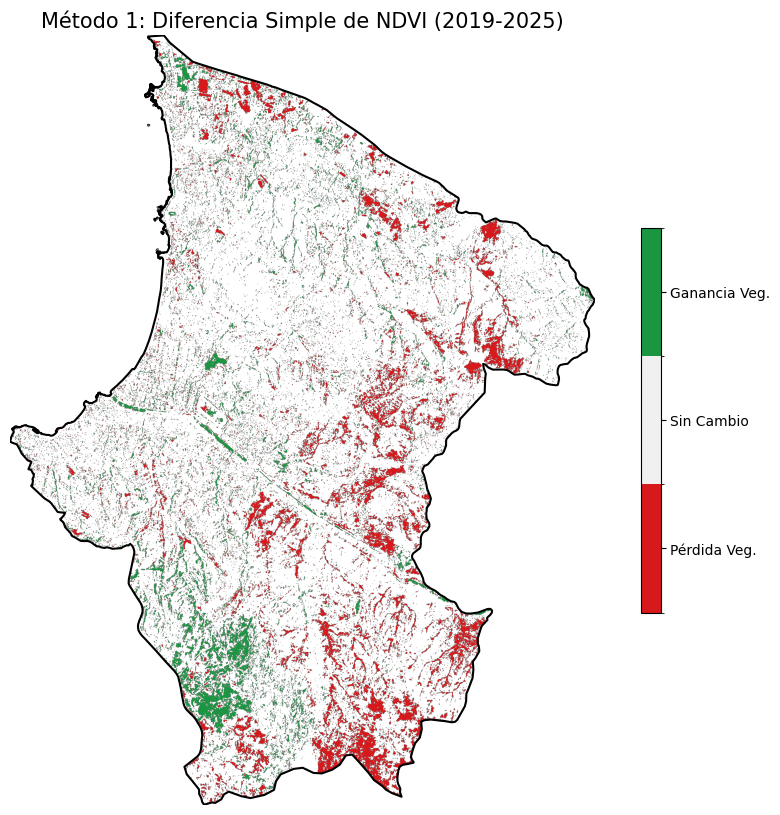

In [17]:
from rasterio.mask import mask
from rasterio.transform import from_origin

file_diff = processed_dir / f"cambio_diferencia_indices_{YEAR_START}_{YEAR_END}.tif"

if file_diff.exists():
    with rasterio.open(file_diff) as src:
        # 1. Preparar vector
        if gdf_limite.crs != src.crs:
            gdf_recorte = gdf_limite.to_crs(src.crs)
        else:
            gdf_recorte = gdf_limite

        # 2. Leer CON RECORT (crop=True) para hacer zoom a la comuna
        # nodata=-99 nos ayuda a diferenciar el fondo del "Sin Cambio" (0)
        out_image, out_transform = mask(src, gdf_recorte.geometry, crop=True, nodata=-99)
        
        data = out_image[0].astype(float)
        data[data == -99] = np.nan # Fondo Transparente
        
        # 3. Calcular la extensión correcta para el gráfico recortado
        # imshow necesita saber las coordenadas del nuevo recorte
        height, width = data.shape
        # (left, right, bottom, top)
        extent = [
            out_transform[2], 
            out_transform[2] + out_transform[0] * width, 
            out_transform[5] + out_transform[4] * height, 
            out_transform[5] 
        ]
        
        # 4. Plotear
        cmap = mcolors.ListedColormap(['#d7191c', '#f0f0f0', '#1a9641'])
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        im = ax.imshow(data, cmap=cmap, norm=norm, extent=extent)
        
        # Borde comunal
        gdf_recorte.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
        
        # Leyenda
        cbar = plt.colorbar(im, ticks=[-1, 0, 1], shrink=0.5)
        cbar.ax.set_yticklabels(['Pérdida Veg.', 'Sin Cambio', 'Ganancia Veg.'])
        
        ax.set_title(f"Método 1: Diferencia Simple de NDVI ({YEAR_START}-{YEAR_END})", fontsize=15)
        ax.axis('off') # Quitar ejes de coordenadas lat/lon si prefieres limpio
        
        plt.savefig(output_dirs["maps"] / "03_mapa_diferencia_simple.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("⚠️ Archivo no encontrado.")

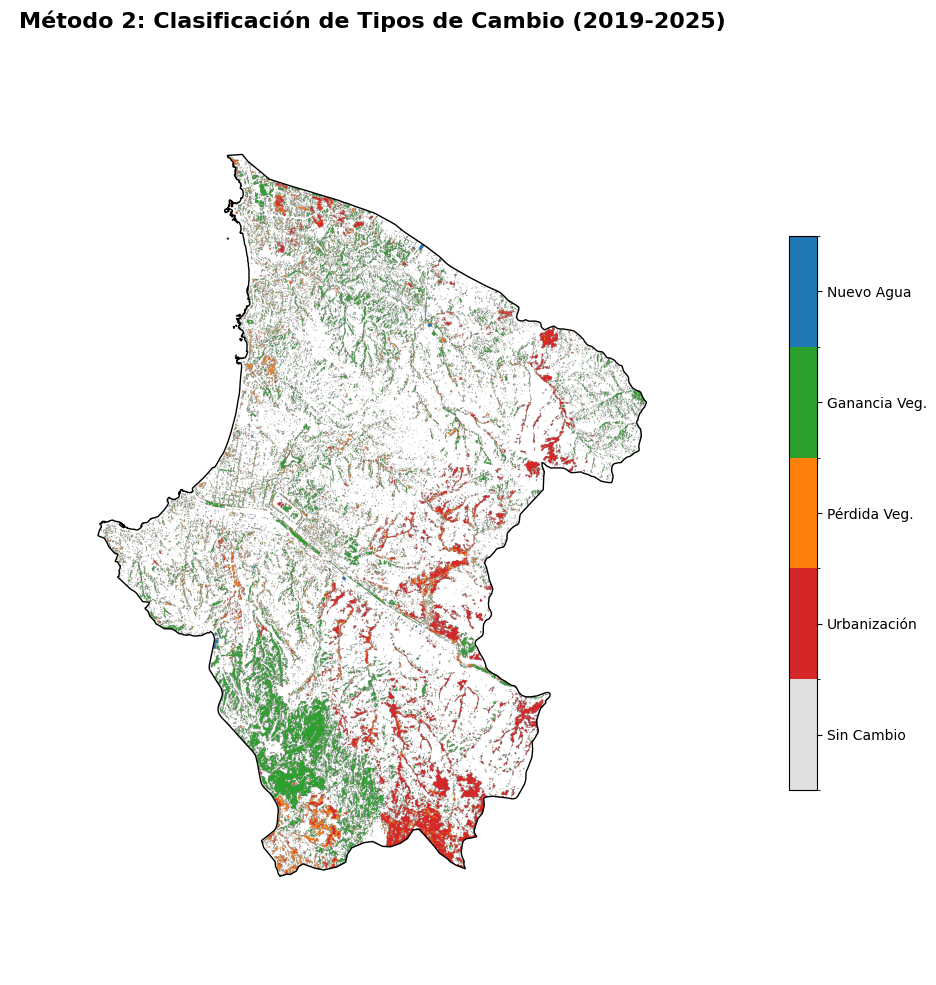

In [9]:
file_urban = processed_dir / f"cambio_urbano_{YEAR_START}_{YEAR_END}.tif"

if file_urban.exists():
    with rasterio.open(file_urban) as src:
        # 1. Preparar recorte
        if gdf_limite.crs != src.crs:
            gdf_recorte = gdf_limite.to_crs(src.crs)
        else:
            gdf_recorte = gdf_limite

        # 2. Leer con máscara (Fondo = -99)
        out_image, out_transform = mask(src, gdf_recorte.geometry, crop=False, nodata=-99)
        
        data = out_image[0].astype(float)
        data[data == -99] = np.nan # Fondo transparente
        
        # Definir Colores Categóricos
        # 0: Sin Cambio (Gris Claro)
        # 1: Urbanización (Rojo)
        # 2: Pérdida Veg (Naranja Quemado)
        # 3: Ganancia Veg (Verde)
        # 4: Nuevo Agua (Azul)
        colors = ['#e0e0e0', '#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
        labels = ['Sin Cambio', 'Urbanización', 'Pérdida Veg.', 'Ganancia Veg.', 'Nuevo Agua']
        
        cmap = mcolors.ListedColormap(colors)
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # Plotear 
        im = ax.imshow(data, cmap=cmap, norm=norm, extent=rasterio.plot.plotting_extent(src))
        gdf_recorte.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
        
        # Leyenda Categórica
        cbar = plt.colorbar(im, ticks=[0, 1, 2, 3, 4], shrink=0.6)
        cbar.ax.set_yticklabels(labels)
        
        ax.set_title(f"Método 2: Clasificación de Tipos de Cambio ({YEAR_START}-{YEAR_END})", fontsize=16, fontweight='bold')
        ax.set_axis_off()
        
        plt.savefig(output_dirs["maps"] / "03_mapa_cambio_urbano_clasificado.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("⚠️ Archivo no encontrado.")

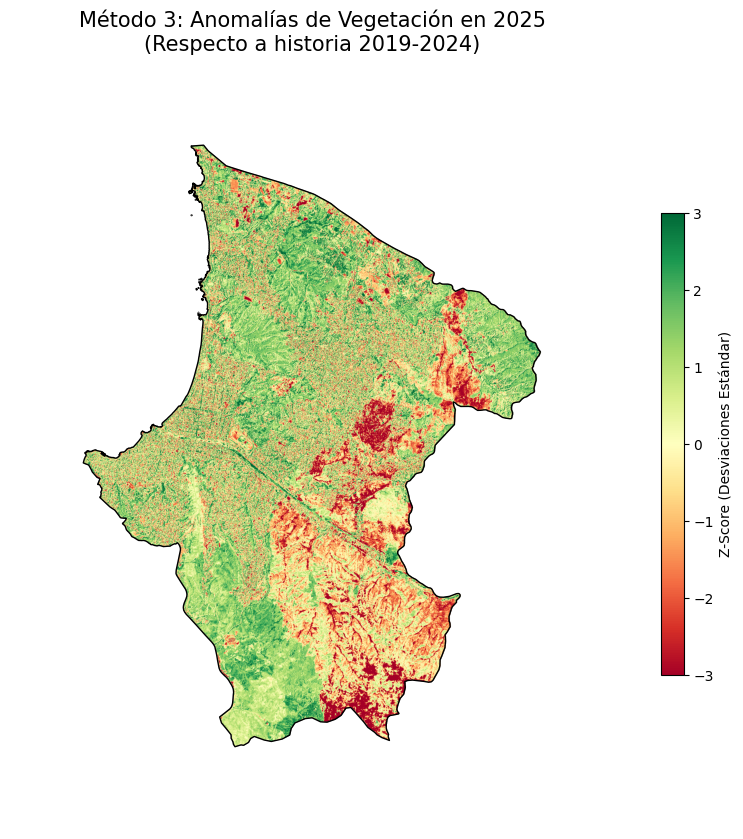

In [7]:
file_anom = processed_dir / f"anomalia_temporal_{YEAR_END}.tif"

if file_anom.exists():
    with rasterio.open(file_anom) as src:
        data = src.read(1)
        
        # --- CORRECCIÓN DE FONDO AMARILLO ---
        # El script guardó el fondo como 0. Lo convertimos a nan para que sea transparente.
        data[data == 0] = np.nan
        
        # Filtros visuales para mejorar el contraste del mapa
        data[data < -3] = -3
        data[data > 3] = 3
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Mapa de calor divergente
        im = ax.imshow(data, cmap='RdYlGn', vmin=-3, vmax=3, extent=rasterio.plot.plotting_extent(src))
        gdf_limite.to_crs(src.crs).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
        
        cbar = plt.colorbar(im, shrink=0.6, label="Z-Score (Desviaciones Estándar)")
        
        ax.set_title(f"Método 3: Anomalías de Vegetación en {YEAR_END}\n(Respecto a historia 2019-{YEAR_END-1})", fontsize=15)
        ax.set_axis_off()
        
        plt.savefig(output_dirs["maps"] / "03_mapa_anomalias_zscore.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("⚠️ Archivo no encontrado.")

⬇️ Verificando/Descargando datos de validación (Dynamic World)...
📍 Los datos de validación se guardarán en: D:\laboratorio_cambio_urbano\data\validation
✅ GEE inicializado.
🚀 Descargando datos de validación (Dynamic World)...
✅ [YA EXISTE] reference_lulc_2019.tif
✅ [YA EXISTE] reference_lulc_2025.tif

🏁 Datos de validación listos.

✅ Datos de validación listos.

📊 Generando Matriz de Confusión...


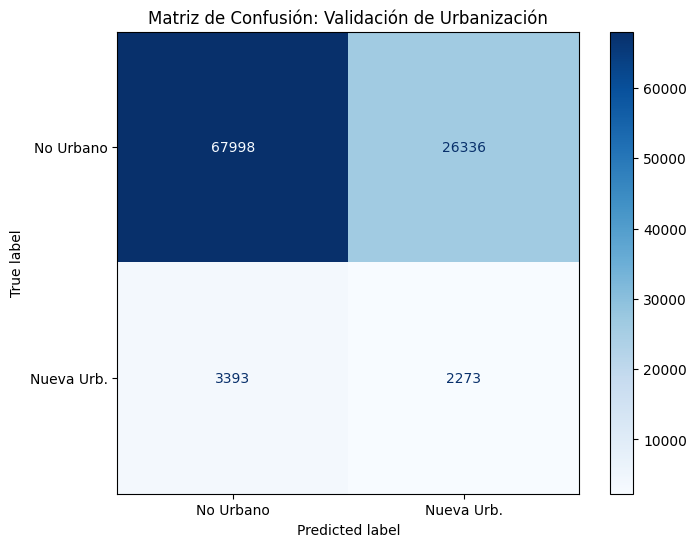

💾 Matriz guardada en CSV: D:\laboratorio_cambio_urbano\outputs\reports\03_matriz_confusion.csv
------------------------------
📊 Precisión (Accuracy de Urbanización): 0.08
🎯 Recall (Sensibilidad): 0.40
⭐ F1-Score: 0.13
------------------------------


In [13]:
# ==============================================================================
# Celda 7: Descarga de Validación, Cálculo de Matriz y Reporte CSV
# ==============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# 1. EJECUCIÓN AUTOMÁTICA DEL SCRIPT DE DESCARGA
# ------------------------------------------------------------------------------
print("⬇️ Verificando/Descargando datos de validación (Dynamic World)...")
script_val = project_root / "scripts" / "download_validation.py"

cmd_val = ["python", str(script_val)]
# Usamos encoding='utf-8' para evitar errores con emojis en Windows
result_val = subprocess.run(cmd_val, capture_output=True, text=True, encoding="utf-8", errors="replace")

if result_val.returncode != 0:
    print("❌ Error descargando validación:")
    print(result_val.stderr)
else:
    print(result_val.stdout)
    print("✅ Datos de validación listos.")

# 2. CÁLCULO DE MATRIZ DE CONFUSIÓN
# ------------------------------------------------------------------------------
print("\n📊 Generando Matriz de Confusión...")

ref_2019_path = project_root / "data" / "validation" / "reference_lulc_2019.tif"
ref_2025_path = project_root / "data" / "validation" / "reference_lulc_2025.tif"

# Verificar que los archivos existan tras la ejecución del script
if ref_2019_path.exists() and ref_2025_path.exists():
    with rasterio.open(ref_2019_path) as src1, rasterio.open(ref_2025_path) as src2:
        # Enmascarar con límite comunal
        ref_2019, _ = mask(src1, gdf_limite.geometry, crop=True)
        ref_2025, _ = mask(src2, gdf_limite.geometry, crop=True)
        
        y_2019 = ref_2019[0].flatten()
        y_2025 = ref_2025[0].flatten()
        
        # --- DEFINIR GROUND TRUTH (VERDAD) ---
        # Cambio Urbano Real: NO era Urbano (6) en 2019 Y SÍ es Urbano (6) en 2025
        cambio_real = np.zeros_like(y_2019, dtype=int)
        mask_urbanizacion_real = (y_2019 != 6) & (y_2025 == 6)
        cambio_real[mask_urbanizacion_real] = 1
        
    # --- CARGAR PREDICCIÓN (MÉTODO 2) ---
    if file_urban.exists():
        with rasterio.open(file_urban) as src_pred:
            pred_img, _ = mask(src_pred, gdf_limite.geometry, crop=True, nodata=-99)
            y_pred_map = pred_img[0].flatten()
            
            # Simplificar a Binario: 1 = Urbanización (Clase 1), 0 = Otro
            y_pred = np.zeros_like(y_pred_map, dtype=int)
            y_pred[y_pred_map == 1] = 1 
            
        # --- FILTRADO Y MUESTREO ---
        # Validar píxeles (ignorar bordes y nubes en referencia)
        valid_pixels = (y_2019 != 0) & (y_pred_map != -99)
        
        indices = np.where(valid_pixels)[0]
        # Sampleo para no saturar memoria (100,000 puntos)
        if len(indices) > 100000:
            indices = np.random.choice(indices, 100000, replace=False)
        
        y_true_sample = cambio_real[indices]
        y_pred_sample = y_pred[indices]
        
        # --- MATRIZ Y GRÁFICO ---
        cm = confusion_matrix(y_true_sample, y_pred_sample)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Urbano", "Nueva Urb."])
        disp.plot(ax=ax, cmap="Blues", values_format="d")
        ax.set_title("Matriz de Confusión: Validación de Urbanización")
        
        plt.savefig(output_dirs["figures"] / "03_matriz_confusion.png", bbox_inches='tight')
        plt.show()
        
        # --- GUARDAR CSV (NUEVO) ---
        df_cm = pd.DataFrame(cm, 
                             index=["Real: No Urbano", "Real: Nueva Urb."], 
                             columns=["Pred: No Urbano", "Pred: Nueva Urb."])
        
        csv_path = output_dirs["reports"] / "03_matriz_confusion.csv"
        df_cm.to_csv(csv_path)
        print(f"💾 Matriz guardada en CSV: {csv_path}")

        # --- MÉTRICAS ---
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print("-" * 30)
        print(f"📊 Precisión (Accuracy de Urbanización): {precision:.2f}")
        print(f"🎯 Recall (Sensibilidad): {recall:.2f}")
        print(f"⭐ F1-Score: {f1:.2f}")
        print("-" * 30)
    else:
        print("⚠️ No se encontró el archivo de predicción (Método 2). Revisa las celdas anteriores.")

else:
    print("⚠️ Error crítico: No se pudieron cargar los datos de validación.")

🗺️ Generando mapa comparativo...
🔍 Píxeles detectados en Ground Truth: 57084.0
🔍 Píxeles detectados en Predicción: 74993.0


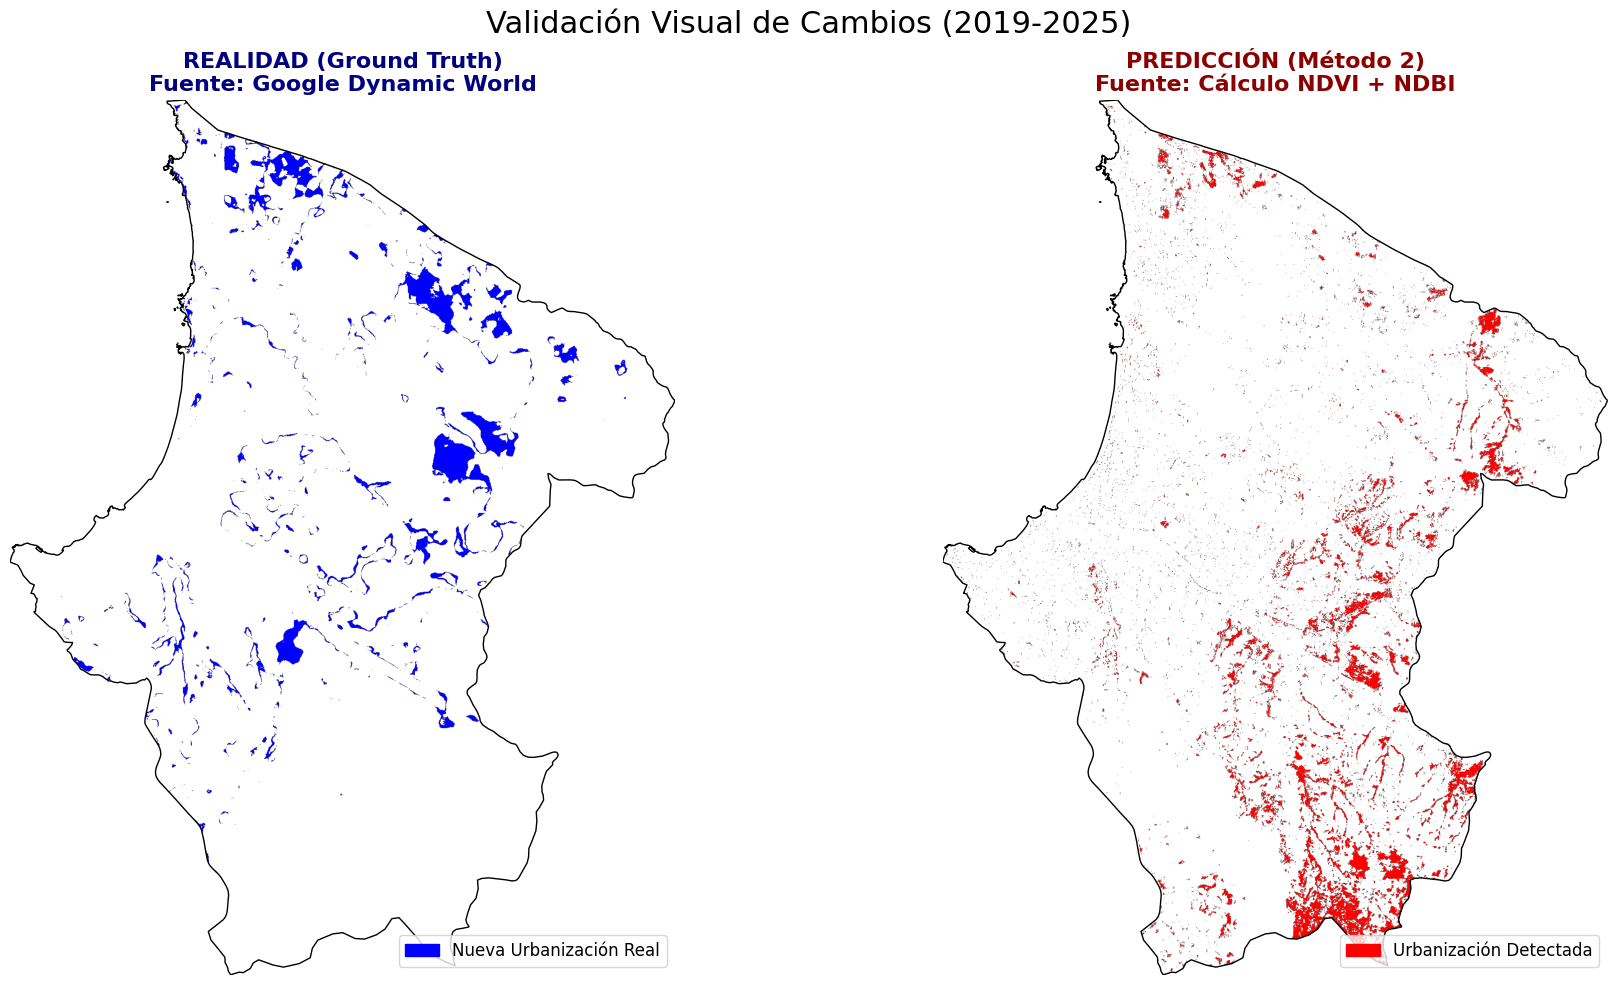

💾 Mapa comparativo guardado en: D:\laboratorio_cambio_urbano\outputs\maps\03_validacion_visual_mapa.png


In [30]:
# ==============================================================================
# Celda 7.1: Mapa Visual de Validación (SIN RELLENO DE FONDO)
# ==============================================================================
import matplotlib.patches as mpatches
from rasterio.mask import mask

print("🗺️ Generando mapa comparativo...")

# Función auxiliar para calcular el extent correcto (Matemáticamente perfecta)
def get_extent_from_transform(transform, width, height):
    minx = transform[2]
    maxx = transform[2] + (width * transform[0])
    maxy = transform[5]
    miny = transform[5] + (height * transform[4])
    return [minx, maxx, miny, maxy]

if 'ref_2019_path' in locals() and ref_2019_path.exists() and file_urban.exists():
    
    # 1. PREPARACIÓN DE DATOS (GROUND TRUTH)
    with rasterio.open(ref_2019_path) as src1, rasterio.open(ref_2025_path) as src2:
        if gdf_limite.crs != src1.crs:
            gdf_recorte = gdf_limite.to_crs(src1.crs)
        else:
            gdf_recorte = gdf_limite

        # Leer recortado (crop=True)
        ref_2019, out_transform = mask(src1, gdf_recorte.geometry, crop=True, nodata=0)
        ref_2025, _ = mask(src2, gdf_recorte.geometry, crop=True, nodata=0)
        
        # Calcular extent
        h, w = ref_2019[0].shape
        extent_gt = get_extent_from_transform(out_transform, w, h)
        
        # Lógica Ground Truth
        cambio_real_map = np.zeros_like(ref_2019[0], dtype=float)
        mask_real = (ref_2019[0] != 6) & (ref_2025[0] == 6) & (ref_2019[0] != 0)
        cambio_real_map[mask_real] = 1
        cambio_real_map[cambio_real_map == 0] = np.nan 

    # 2. PREPARACIÓN DE DATOS (PREDICCIÓN)
    with rasterio.open(file_urban) as src_pred:
        pred_img, out_transform_pred = mask(src_pred, gdf_recorte.geometry, crop=True, nodata=-99)
        pred_data = pred_img[0].astype(float)
        
        h_p, w_p = pred_data.shape
        extent_pred = get_extent_from_transform(out_transform_pred, w_p, h_p)
        
        pred_urban = np.zeros_like(pred_data)
        pred_urban[pred_data == 1] = 1
        pred_urban[pred_urban == 0] = np.nan 

    # --- DIAGNÓSTICO RÁPIDO ---
    # Esto te dirá si el problema son los colores o que los datos están vacíos
    print(f"🔍 Píxeles detectados en Ground Truth: {np.nansum(cambio_real_map)}")
    print(f"🔍 Píxeles detectados en Predicción: {np.nansum(pred_urban)}")

    # 3. PLOTEO
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    cmap_google = mcolors.ListedColormap(['blue']) 
    cmap_pred   = mcolors.ListedColormap(['red'])

    # --- MAPA 1: REALIDAD ---
    # CAPA 1: El Raster (Datos) va PRIMERO
    ax[0].imshow(cambio_real_map, cmap=cmap_google, extent=extent_gt, zorder=1)
    
    # CAPA 2: El Vector (Borde) va ENCIMA (zorder=2) y SIN RELLENO (facecolor='none')
    gdf_recorte.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidth=1, zorder=2)
    
    ax[0].set_title("REALIDAD (Ground Truth)\nFuente: Google Dynamic World", fontsize=16, fontweight='bold', color='navy')
    ax[0].axis('off')
    
    legend_google = [mpatches.Patch(color='blue', label='Nueva Urbanización Real')]
    ax[0].legend(handles=legend_google, loc='lower right', fontsize=12)

    # --- MAPA 2: PREDICCIÓN ---
    # CAPA 1: El Raster (Datos)
    ax[1].imshow(pred_urban, cmap=cmap_pred, extent=extent_pred, zorder=1)
    
    # CAPA 2: El Vector (Borde) -> facecolor='none' es la clave
    gdf_recorte.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidth=1, zorder=2)
    
    ax[1].set_title("PREDICCIÓN (Método 2)\nFuente: Cálculo NDVI + NDBI", fontsize=16, fontweight='bold', color='darkred')
    ax[1].axis('off')
    
    legend_pred = [mpatches.Patch(color='red', label='Urbanización Detectada')]
    ax[1].legend(handles=legend_pred, loc='lower right', fontsize=12)
    
    plt.suptitle(f"Validación Visual de Cambios ({YEAR_START}-{YEAR_END})", fontsize=22, y=0.98)
    plt.tight_layout()
    
    save_path = output_dirs["maps"] / "03_validacion_visual_mapa.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"💾 Mapa comparativo guardado en: {save_path}")

else:
    print("⚠️ Faltan archivos para generar el mapa.")